In [4]:
import os
import pickle

import community.community_louvain as community_louvain
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from shapely.geometry import Point
import contextily as ctx

from constants import (
    AGGR_GRAPH_PATH,
    COMMUNITY_PARTITIONS_FPATH,
    DISTANCE_NEGATIVE_THRESHOLD,
    DISTANCE_POSITIVE_THRESHOLD,
    FINAL_GRAPH_PATH,
)

In [ ]:
G = nx.read_graphml(AGGR_GRAPH_PATH)
print("Graph loaded successfully.")
UG = nx.Graph(G)
print("Nodes:", UG.number_of_nodes())
print("Edges:", UG.number_of_edges())

In [ ]:
pos = {}
for n, data in UG.nodes(data=True):
    try:
        x = float(data.get("x"))
        y = float(data.get("y"))
        pos[n] = (x, y)
    except (TypeError, ValueError):
        pos[n] = None

pos = {n: p for n, p in pos.items() if p is not None}

print("Nodes with coordinates:", len(pos))

# Connected components
cc = list(nx.connected_components(UG))
print("Connected components:", len(cc))
largest_cc = max(cc, key=len)
smallest_cc = min(cc, key=len)
print("Largest CC size:", len(largest_cc))
print("Smallest CC size:", len(smallest_cc))

## Louvain + One-Hot Encoding Community Labels

In [ ]:
if not os.path.exists(COMMUNITY_PARTITIONS_FPATH):
    print("Computing communities.")
    partition = community_louvain.best_partition(UG, resolution=2.0)
    
    with open(COMMUNITY_PARTITIONS_FPATH, "wb") as f:
        pickle.dump(partition, f)
else:
    print("Community partitions found. Loading.")
    with open(COMMUNITY_PARTITIONS_FPATH, "rb") as f:
        partition = pickle.load(f)

In [ ]:
comm_ids = sorted(set(partition.values()))
col_names = {cid: f"comm_{i}" for i, cid in enumerate(comm_ids)}

attrs = {}
for n in UG.nodes():
    node_comm = partition.get(n)
    # create one-hot dict with all zeros then set the community column to 1
    d = {name: 0 for name in col_names.values()}
    if node_comm is not None:
        d[col_names[node_comm]] = 1
    attrs[n] = d

nx.set_node_attributes(UG, attrs)

num_comms = len(set(partition.values()))
print(f"Detected communities: {num_comms}")

In [ ]:
unique_coms = sorted(set(partition.values()))
color_map = {c: i for i, c in enumerate(unique_coms)}
node_colors = [color_map[partition[n]] for n in UG.nodes()]

plt.figure(figsize=(10, 8))
plt.title(
    f"Louvain Communities of Lahore Road Network ({num_comms} communities)", fontsize=12
)

nx.draw_networkx_nodes(
    UG,
    pos=pos,
    node_size=3,
    node_color=node_colors,
    cmap=plt.cm.tab20,  # type: ignore
    alpha=0.85,
)

nx.draw_networkx_edges(UG, pos=pos, width=0.2, edge_color="gray", alpha=0.4)

plt.axis("off")
plt.tight_layout()
plt.show()

#### Generate Labels

In [ ]:
nodes_df = pd.DataFrame.from_dict(dict(UG.nodes(data=True)), orient="index")

In [ ]:
nodes_df["distance_to_nearest_stop"] = nodes_df["distance_to_nearest_stop"].astype(
    float
)


def label_fn(dist):
    if dist < DISTANCE_POSITIVE_THRESHOLD:
        return 1  # Success; we are not in a transit desert
    elif dist > DISTANCE_NEGATIVE_THRESHOLD:
        return 0  # Woe; we are in a transit desert
    else:
        return np.nan


nodes_df["label"] = nodes_df["distance_to_nearest_stop"].apply(label_fn)

nx.set_node_attributes(UG, nodes_df["label"].to_dict(), name="label")

In [ ]:
if not os.path.exists(FINAL_GRAPH_PATH):
    print("Saving final graph.")
    with open(FINAL_GRAPH_PATH, "wb") as f:
        pickle.dump(UG, f)

## Load Graph

In [2]:
with open(FINAL_GRAPH_PATH,'rb') as f:
    G=pickle.load(f)

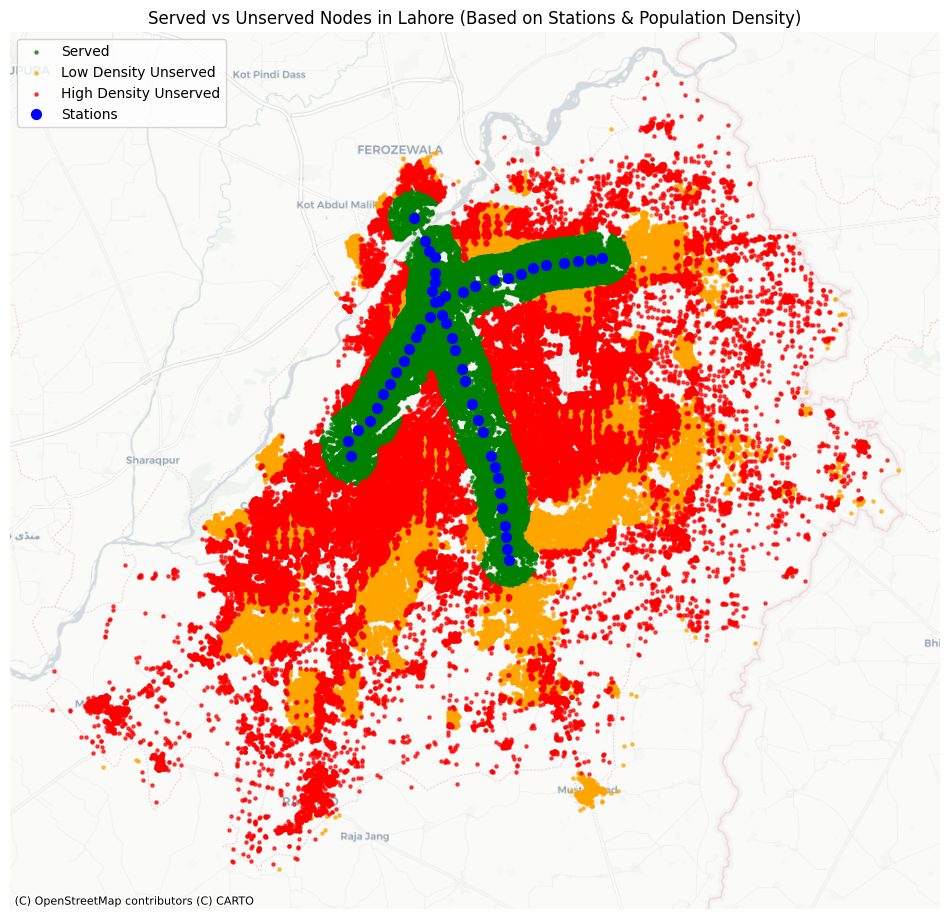

In [5]:
def get_attr(node, key, default=0.0):  # Numeric Conversion as values are saved in string format
    try:
        return float(G.nodes[node].get(key, default))
    except:
        return default

# ------------------------------
# Define thresholds
# ------------------------------
DIST_THRESHOLD = 2000  # meters
pop_values = [get_attr(n, "population") for n in G.nodes()]
POP_MEDIAN = np.median(pop_values)

# ------------------------------
# Classify nodes
# ------------------------------
node_records = []
for n in G.nodes():
    x, y = get_attr(n, "x"), get_attr(n, "y")
    if x is None or y is None:
        continue

    dist = get_attr(n, "distance_to_nearest_stop")
    pop = get_attr(n, "population")

    if dist <= DIST_THRESHOLD:
        status = "served"
    elif dist > DIST_THRESHOLD and pop <= POP_MEDIAN:
        status = "low_density_unserved"
    else:
        status = "high_density_unserved"

    node_records.append({
        "geometry": Point(x, y),
        "population": pop,
        "distance_to_station": dist,
        "served_status": status
    })

# ------------------------------
# Create GeoDataFrame
# ------------------------------
utm_crs = "EPSG:32643"  # UTM zone 43N for Lahore
gdf_nodes = gpd.GeoDataFrame(node_records, crs=utm_crs)

# ------------------------------
# Load stations
# ------------------------------
gdf_stations = gpd.read_file("../data/citylines/lahore_stations.geojson")
gdf_stations = gdf_stations.to_crs(utm_crs)

# ------------------------------
# Reproject to Web Mercator for basemap
# ------------------------------
gdf_nodes = gdf_nodes.to_crs(epsg=3857)
gdf_stations = gdf_stations.to_crs(epsg=3857)

# ------------------------------
# Plot nodes
# ------------------------------
fig, ax = plt.subplots(figsize=(12, 12))

colors = {
    "served": "green",
    "low_density_unserved": "orange",
    "high_density_unserved": "red"
}

for status, color in colors.items():
    gdf_nodes[gdf_nodes["served_status"] == status].plot(
        ax=ax, color=color, markersize=5, alpha=0.7, label=status.replace("_", " ").title()
    )

gdf_stations.plot(ax=ax, color="blue", markersize=50, marker="o", label="Stations")

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

ax.set_title("Served vs Unserved Nodes in Lahore (Based on Stations & Population Density)")
ax.set_axis_off()
plt.legend()
plt.show()


In [7]:
for key, value in G.graph.items():
    print(f"{key}: {value}")

node_default: {}
edge_default: {}
created_date: 2025-11-06 08:20:22
created_with: OSMnx 2.0.6
crs: EPSG:32643
simplified: True


In [ ]:
import pickle
import networkx as nx
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import community.community_louvain as louvain


# -------------------------------------------------------------------
# 1. Load graph
# -------------------------------------------------------------------



# -------------------------------------------------------------------
# 2. Safe numeric extractor (critical fix)
# -------------------------------------------------------------------
def get_attr(node, key, default=0.0):
    try:
        return float(G.nodes[node].get(key, default))
    except:
        return default


# -------------------------------------------------------------------
# 3. Build feature matrix SAFELY
# -------------------------------------------------------------------
features = ["street_count", "population", "distance_to_nearest_stop"]

X = np.array([
    [get_attr(n, "street_count"),
     get_attr(n, "population"),
     get_attr(n, "distance_to_nearest_stop")]
    for n in G.nodes()
])


# -------------------------------------------------------------------
# 4. Normalize
# -------------------------------------------------------------------
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)

for i, n in enumerate(G.nodes()):
    G.nodes[n]["street_n"] = X_norm[i, 0]
    G.nodes[n]["pop_n"] = X_norm[i, 1]
    G.nodes[n]["dist_n"] = X_norm[i, 2]



for n in G.nodes():
    dist = get_attr(n, "distance_to_nearest_stop", 9999)

    G.nodes[n]["access_score"] = (
        0.6 * (1 / (dist + 1e-6)) +
        0.25 * G.nodes[n]["street_n"] +
        0.15 * G.nodes[n]["pop_n"]
    )


with open(COMMUNITY_PARTITIONS_FPATH,"rb") as f:
    partition = pickle.load(f)



comm_stats = {}

for n in G.nodes():
    cid = G.nodes[n]["community"]
    if cid not in comm_stats:
        comm_stats[cid] = {"distances": [], "access": [], "population": []}

    comm_stats[cid]["distances"].append(get_attr(n, "distance_to_nearest_stop"))
    comm_stats[cid]["access"].append(G.nodes[n]["access_score"])
    comm_stats[cid]["population"].append(get_attr(n, "population"))


community_labels = {}

# threshold based on normalized distance
dist_threshold = np.median(X_norm[:, 2])

for cid, stats in comm_stats.items():
    avg_dist = np.mean(stats["distances"])
    avg_access = np.mean(stats["access"])

    if avg_dist < 1000 and avg_access > dist_threshold:
        community_labels[cid] = "served"
    else:
        community_labels[cid] = "unserved"


# assign served/unserved to nodes
for n in G.nodes():
    cid = G.nodes[n]["community"]
    G.nodes[n]["served_status"] = community_labels[cid]


print("Pipeline completed successfully.")


Pipeline completed successfully.


In [10]:
with open("final_processed.gpickle", "wb") as f:
    pickle.dump(G, f)
print("Graph saved as 'final_processed.gpickle'.")

Graph saved as 'final_processed.gpickle'.


In [2]:
from sklearn.preprocessing import MinMaxScaler
import community.community_louvain as louvain
with open("final_processed.gpickle", "rb") as f:
    G = pickle.load(f)

partition = louvain.best_partition(G)

for node, cid in partition.items():
    G.nodes[node]["community"] = cid
num_comms = len(set(partition.values()))
colors = plt.cm.get_cmap("tab20", num_comms)

node_colors = [
    colors(G.nodes[n]["community"]) if G.nodes[n]["served_status"]=="served"
    else (0.8, 0.8, 0.8, 1.0)  # light gray for unserved
    for n in G.nodes()
]

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)  # positions for all nodes

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=50)
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.title("Graph: Communities and Served/Unserved Nodes")
plt.axis("off")
plt.show()

/tmp/ipykernel_26930/2645275616.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", num_comms)


KeyboardInterrupt: 

<Figure size 1200x1200 with 0 Axes>

In [3]:
served_comms = set()
unserved_comms = set()

for n in G.nodes():
    comm = G.nodes[n]["community"]
    status = G.nodes[n]["served_status"]
    if status == "served":
        served_comms.add(comm)
    else:
        unserved_comms.add(comm)

print("Served communities:", served_comms)
print("Unserved communities:", unserved_comms)

Served communities: {106, 14, 15, 16, 17, 18, 119, 21, 87, 23, 20, 60, 127}
Unserved communities: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178}


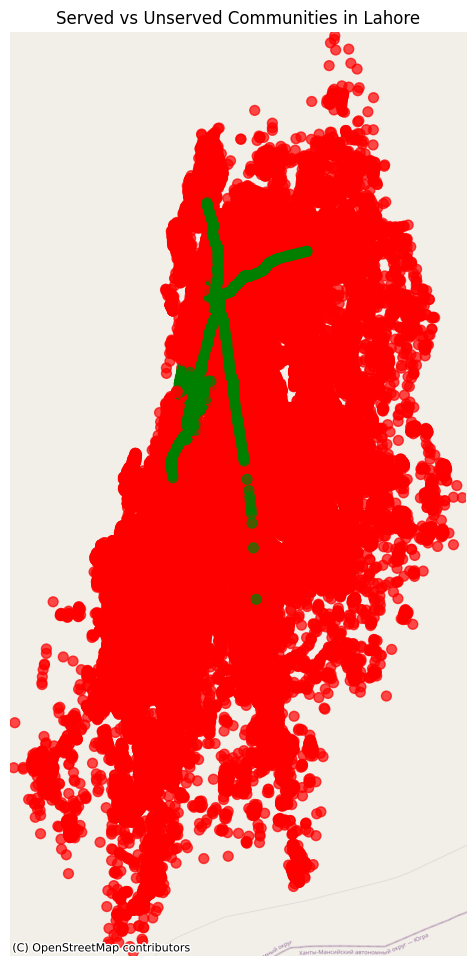

In [15]:
import pickle
import networkx as nx
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import contextily as ctx

# Lahore center (lat/lon)
LHR_LAT = 31.456845
LHR_LON = 74.407836

# Load graph
with open("final_processed.gpickle", "rb") as f:
    G = pickle.load(f)

# Build GeoDataFrame
nodes_data = []
for n in G.nodes():
    x = G.nodes[n].get("x")
    y = G.nodes[n].get("y")
    status = G.nodes[n].get("served_status", "unserved")
    
    if x is not None and y is not None:
        # convert to float safely
        try:
            x = float(x)
            y = float(y)
        except ValueError:
            continue  # skip if cannot convert
        
        # convert local coordinates to approximate lat/lon around central point
        lon = LHR_LON + x / 111000  # meters -> degrees
        lat = LHR_LAT + y / 111000
        
        nodes_data.append({"geometry": Point(lon, lat), "served_status": status})

gdf_nodes = gpd.GeoDataFrame(nodes_data, crs="EPSG:4326")  # WGS84

# Convert to Web Mercator for basemap
gdf_nodes = gdf_nodes.to_crs(epsg=3857)

# Plot
fig, ax = plt.subplots(figsize=(12, 12))
gdf_nodes.plot(
    ax=ax, 
    color=gdf_nodes["served_status"].map({"served":"green","unserved":"red"}), 
    markersize=50, 
    alpha=0.7
)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Adjust plot limits
ax.set_xlim(gdf_nodes.geometry.x.min() - 500, gdf_nodes.geometry.x.max() + 500)
ax.set_ylim(gdf_nodes.geometry.y.min() - 500, gdf_nodes.geometry.y.max() + 500)

ax.set_title("Served vs Unserved Communities in Lahore")
ax.axis("off")
plt.show()


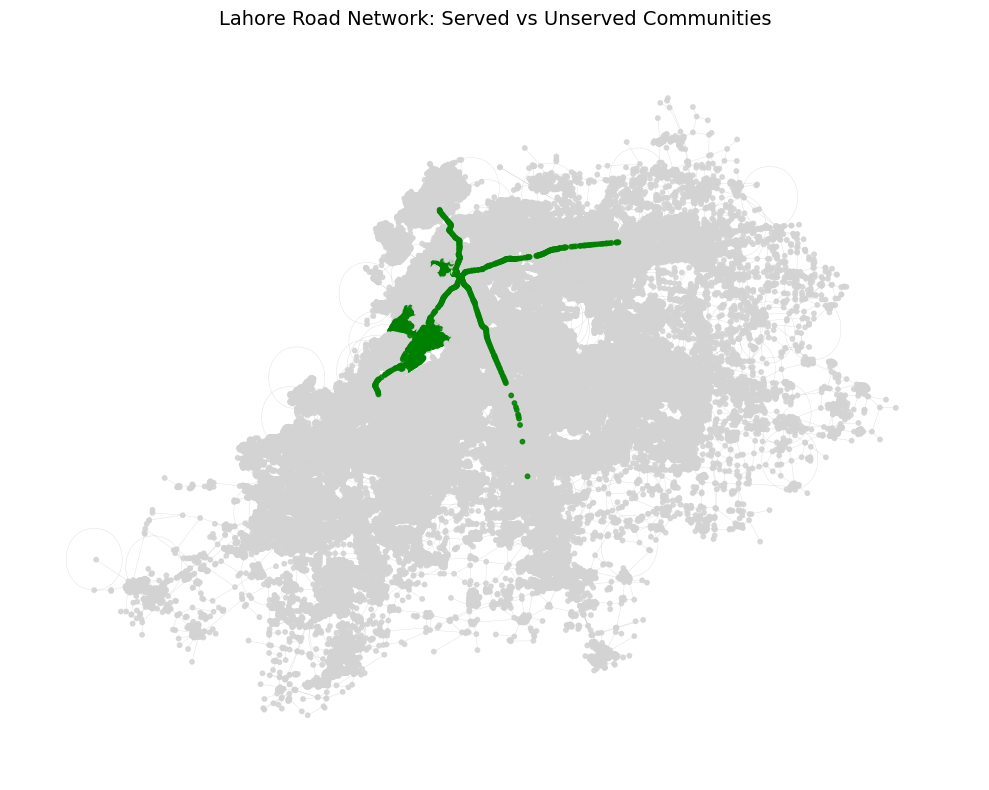

In [6]:
import pickle
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter

# Load graph and partition
with open(COMMUNITY_PARTITIONS_FPATH, "rb") as f:
    partition = pickle.load(f)
with open("final_processed.gpickle", "rb") as f:
    G = pickle.load(f)

# Ensure nodes have community
for n in G.nodes():
    G.nodes[n]["community"] = partition[n]

# Build node positions
pos = {}
for n, data in G.nodes(data=True):
    try:
        x = float(data.get("x"))
        y = float(data.get("y"))
        pos[n] = (x, y)
    except (TypeError, ValueError):
        pass

# Determine served/unserved for each community (majority vote of nodes)
community_labels = {}
for cid in set(partition.values()):
    nodes_in_comm = [n for n in G.nodes() if G.nodes[n]["community"] == cid]
    statuses = [G.nodes[n].get("served_status", "unserved") for n in nodes_in_comm]
    majority_status = Counter(statuses).most_common(1)[0][0]
    community_labels[cid] = majority_status

# Assign colors based on community served/unserved
color_map = {"served": "green", "unserved": "lightgray"}
node_colors = [color_map[community_labels[partition[n]]] for n in pos.keys()]

# Plot
plt.figure(figsize=(10, 8))
plt.title("Lahore Road Network: Served vs Unserved Communities", fontsize=14)

nx.draw_networkx_nodes(
    G,
    pos=pos,
    node_size=10,
    node_color=node_colors,
    alpha=0.85,
)

nx.draw_networkx_edges(
    G,
    pos=pos,
    width=0.2,
    edge_color="gray",
    alpha=0.4,
)

plt.axis("off")
plt.tight_layout()
plt.show()
